In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import time

In [41]:
def createSomeData(nPerClust):
    A=[1,1]
    B=[5,1]
    C=[4,4]
    
    a=[A[0]+np.random.randn(nPerClust),A[1]+np.random.randn(nPerClust)]
    b=[B[0]+np.random.randn(nPerClust),B[1]+np.random.randn(nPerClust)]
    c=[C[0]+np.random.randn(nPerClust),C[1]+np.random.randn(nPerClust)]
    
    labels_np=np.hstack((np.zeros((nPerClust)),
                         np.ones((nPerClust)),
                         1+np.ones((nPerClust)) ))
    
    data_np=np.hstack((a,b,c)).T
    
    output={}
    output['data']=torch.tensor(data_np).float()
    output['label']=torch.tensor(labels_np).long()
    
    train_data,test_data,train_label,test_label=train_test_split(
                output['data'],output['label'], train_size=.9)
    
    train_dataset=TensorDataset(train_data,train_label)
    test_dataset=TensorDataset(test_data,test_label)
    
    output['train_loader']=DataLoader(train_dataset,batch_size=16,\
                                      shuffle=True,drop_last=True)
    output['test_loader']=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])
    
    return output

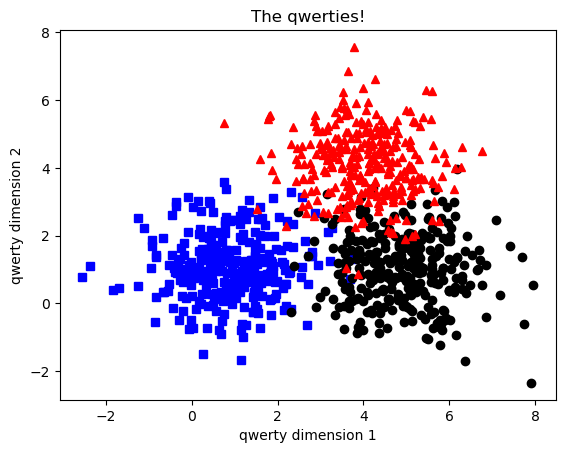

In [27]:
dataset=createSomeData(300)
data=dataset['data']
label=dataset['label']
data.shape

plt.plot(data[np.where(label==0)[0],0],data[np.where(label==0)[0],1],'bs')
plt.plot(data[np.where(label==1)[0],0],data[np.where(label==1)[0],1],'ko')
plt.plot(data[np.where(label==2)[0],0],data[np.where(label==2)[0],1],'r^')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')

plt.show()

In [8]:
def createModel(nUnits,nLayers):
    
    class annModel(nn.Module):
        
        def __init__(self,nUnits,nLayers):
            super().__init__()
            
            self.layers=nn.ModuleDict()
            self.nLayers=nLayers
            
            self.layers['input']=nn.Linear(2,nUnits)
            
            for i in range(nLayers):
                self.layers[f'hidden{i}']=nn.Linear(nUnits,nUnits)
                
            self.layers['output']=nn.Linear(nUnits,3)
            
        def forward(self,x):
            x=F.relu( self.layers['input'](x) )
            
            for i in range(self.nLayers):
                x=F.relu( self.layers[f'hidden{i}'](x) )
            
            x=self.layers['output'](x)
            
            return x
        
    ann=annModel(nUnits,nLayers)
    
    lossfun=nn.CrossEntropyLoss()
    
    optimizer=torch.optim.SGD(ann.parameters(),lr=.01)
    
    return ann,lossfun,optimizer

In [32]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

def trainModelwithGpu(nUnits,nLayers,Numepoch=100):
    
    #train and test accuracies over each epoch
    trainAcc=[]
    testAcc=[]
    losses=torch.zeros(Numepoch)
    
    #the time spended training process
    processTime=time.process_time()
    
    
    
    #create new ann model
    ANN,lossfun,optimizer=createModel(nUnits,nLayers)
    
    ANN.to(device)
    
    for epoch in range(Numepoch):
        # time
        startTime=time.process_time()
        
        #accuracy and loss over one epoch
        batchAcc=[]
        batchLoss=[]
        
        ANN.train()
        
        for dat,lab in train_loader:
            
            dat=dat.to(device)
            lab=lab.to(device)
            
            yHat=ANN(dat)
            loss=lossfun(yHat,lab)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            yHat=yHat.cpu()
            lab=lab.cpu()
            
            match=(torch.argmax(yHat,axis=1)==lab).float()
            batchAcc.append(100*torch.mean(match).item())
            
            
        
        trainAcc.append(np.mean(batchAcc))
        losses[epoch]=np.mean(batchLoss)

        ANN.eval()
        dat,lab=next(iter(test_loader))
        
        dat=dat.to(device)
        lab=lab.to(device)
            
        with torch.no_grad():
            yHat=ANN(dat)
        
        yHat=yHat.cpu()
        lab=lab.cpu()
            
        testAcc.append(100*torch.mean( (torch.argmax(yHat,axis=1)==lab).float()))
        
        completedTime=time.process_time()-startTime
        
#         print(f'{epoch+1}-th trainAcc:{trainAcc[epoch]},----testAcc{testAcc[epoch]},----lossValue:{losses[epoch]},---CompTime {completedTime:.2f}-sec')
        
    processTime=time.process_time()-processTime  

    return ANN,trainAcc,testAcc,losses,processTime

cuda:0


In [42]:
Data=createSomeData(3000)
train_loader=Data['train_loader']
test_loader=Data['test_loader']

ANN,trainAcc,testAcc,losses,processTime=trainModelwithGpu(20,4,50)

the time spended for complete of training:48.15625


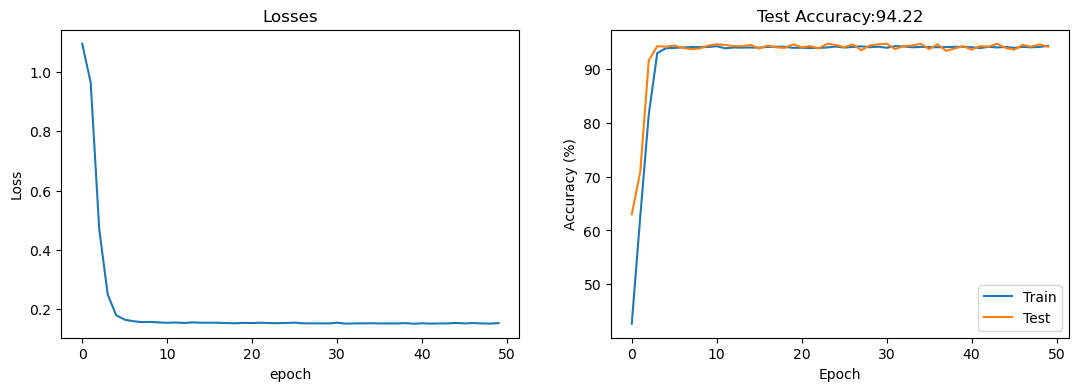

In [40]:
fig,ax=plt.subplots(1,2,figsize=(13,4))
print(f'the time spended for complete of training:{processTime}')
ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Test Accuracy:{testAcc[-1]:.2f}')
ax[1].legend()
plt.show()

tensor(0.9473)


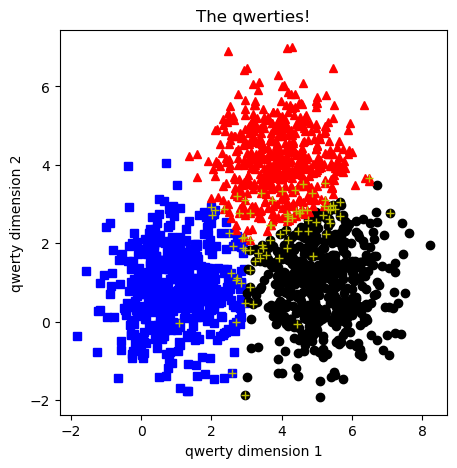

In [44]:
dataset=createSomeData(500)
data=dataset['data']
labels=dataset['label']

data=data.to(device)
predict=ANN(data)


data=data.cpu()
predict=predict.cpu()

predict=torch.argmax(predict,axis=1)
print(torch.mean((predict==labels).float()))

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(predict==0)[0],0],data[np.where(predict==0)[0],1],'bs')
plt.plot(data[np.where(predict==1)[0],0],data[np.where(predict==1)[0],1],'ko')
plt.plot(data[np.where(predict==2)[0],0],data[np.where(predict==2)[0],1],'r^')
plt.plot(data[np.where(predict!=labels)[0],0],data[np.where(predict!=labels)[0],1],'y+',)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()


testing differente neural network archiectures and data numbers

In [9]:
nodesNumber=80
layrange=[1,3,7,15,20]
dataNumber=np.arange(50,551,50)

results=np.zeros((len(dataNumber),len(layrange),2))

legend=[]

for Didx,num in enumerate(dataNumber):
    
    data=createSomeData(num)
    train_loader=data['train_loader']
    test_loader=data['test_loader']
    
    for Lidx,layer in enumerate(layrange):
        
        units=int(nodesNumber/layer)
        ANN,trainAcc,testAcc,losses,processTime=trainModelwithGpu(units,layer)
        
        nparam=np.sum([p.numel() for p in ANN.parameters() if p.requires_grad])
        
        legend.append('%s layers, %s units, %s param' %(layer,units,nparam))
        
        results[Didx,Lidx,0]=np.mean(testAcc[-5:])
        results[Didx,Lidx,1]=torch.mean(losses[-5:]).item()
        print(f"completed at time:{processTime}")
    

completed at time:1.484375
completed at time:1.328125
completed at time:2.078125
completed at time:3.515625
completed at time:4.703125
completed at time:2.3125
completed at time:2.671875
completed at time:4.734375
completed at time:7.078125
completed at time:9.65625
completed at time:2.859375
completed at time:4.75
completed at time:7.03125
completed at time:11.453125
completed at time:14.78125
completed at time:3.46875
completed at time:4.75
completed at time:7.828125
completed at time:13.515625
completed at time:18.484375
completed at time:5.3125
completed at time:6.609375
completed at time:10.140625
completed at time:19.96875
completed at time:28.46875
completed at time:7.421875
completed at time:7.8125
completed at time:13.46875
completed at time:25.28125
completed at time:28.265625
completed at time:8.28125
completed at time:9.71875
completed at time:15.46875
completed at time:28.171875
completed at time:35.765625
completed at time:9.03125
completed at time:12.71875
completed at t

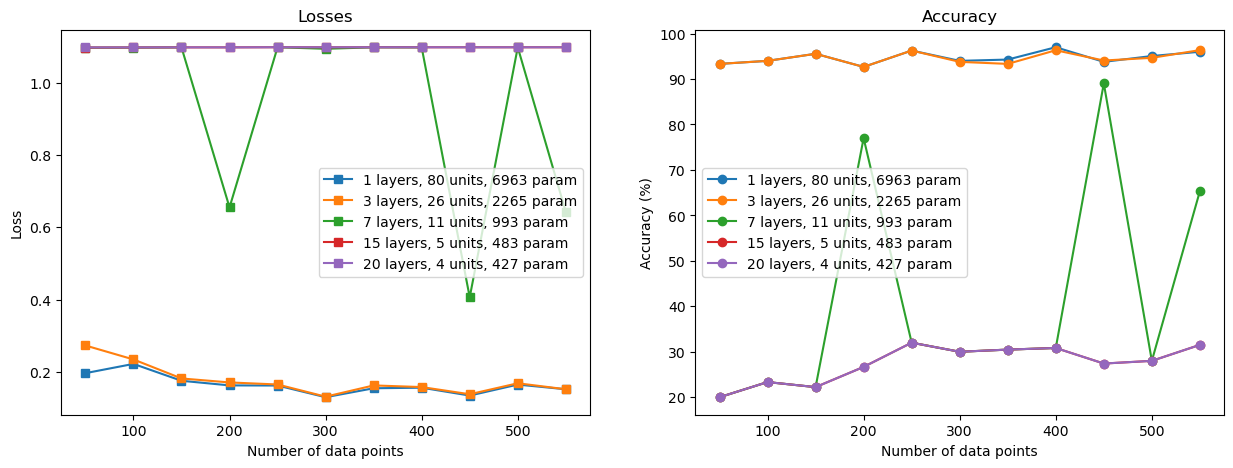

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(dataNumber,results[:,:,1],'s-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(dataNumber,results[:,:,0],'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].set_title('Accuracy')
ax[1].legend(legend)
plt.show()
